In [1]:
import grid2op
from grid2op.PlotGrid import PlotMatplot
import numpy as np
from lightsim2grid import LightSimBackend
from grid2op.utils import EpisodeStatistics
import os

In [2]:
env = grid2op.make("educ_case14_storage_custom",
                    backend=LightSimBackend()
                    )

In [11]:
import numpy as np
from grid2op.Reward.BaseReward import BaseReward
from grid2op.dtypes import dt_float

class L2RPNReward_test(BaseReward):
    """
    This is the historical :class:`BaseReward` used for the Learning To Run a Power Network competition on WCCI 2019

    See `L2RPN <https://l2rpn.chalearn.org/>`_ for more information.

    This rewards makes the sum of the "squared margin" on each powerline.

    The margin is defined, for each powerline as:
    `margin of a powerline = (thermal limit - flow in amps) / thermal limit`
    (if flow in amps <= thermal limit) else `margin of a powerline  = 0.`

    This rewards is then: `sum (margin of this powerline) ^ 2`, for each powerline.


    Examples
    ---------
    You can use this reward in any environment with:

    .. code-block:

        import grid2op
        from grid2op.Reward import L2RPNReward

        # then you create your environment with it:
        NAME_OF_THE_ENVIRONMENT = "rte_case14_realistic"
        env = grid2op.make(NAME_OF_THE_ENVIRONMENT,reward_class=L2RPNReward)
        # and do a step with a "do nothing" action
        obs = env.reset()
        obs, reward, done, info = env.step(env.action_space())
        # the reward is computed with the L2RPNReward class

    """

    def __init__(self, logger=None):
        BaseReward.__init__(self, logger=logger)


    def initialize(self, env):
        self.reward_min = dt_float(0.0)
        self.reward_max = dt_float(env.backend.n_line)


    def __call__(self, action, env, has_error, is_done, is_illegal, is_ambiguous):
        if not is_done and not has_error:
            line_cap = self.__get_lines_capacity_usage(env)
            res = np.sum(line_cap)
        else:
            # no more data to consider, no powerflow has been run, reward is what it is
            res = self.reward_min
        # print(f"\t env.backend.get_line_flow(): {env.backend.get_line_flow()}")
        return res

    @staticmethod
    def __get_lines_capacity_usage(env):
        ampere_flows = np.abs(env.backend.get_line_flow(), dtype=dt_float)
        thermal_limits = np.abs(env.get_thermal_limit(), dtype=dt_float)
        thermal_limits += 1e-1  # for numerical stability
        relative_flow = np.divide(ampere_flows, thermal_limits, dtype=dt_float)

        x = np.minimum(relative_flow, dt_float(1.0))
        lines_capacity_usage_score = np.maximum(
            dt_float(1.0) - x**2, np.zeros(x.shape, dtype=dt_float)
        )
        return lines_capacity_usage_score

In [3]:
from grid2op.Reward import GameplayReward, L2RPNReward

env = grid2op.make("educ_case14_storage_custom",
                    backend=LightSimBackend(),
                    reward_class=L2RPNReward,
                    other_rewards={"gameplay": GameplayReward}
                    )
obs = env.reset()
obs, reward, done, info = env.step(env.action_space())
reward, info

(15.51548,
 {'disc_lines': array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1], dtype=int32),
  'is_illegal': False,
  'is_ambiguous': False,
  'is_dispatching_illegal': False,
  'is_illegal_reco': False,
  'reason_alarm_illegal': None,
  'opponent_attack_line': None,
  'opponent_attack_sub': None,
  'opponent_attack_duration': 0,
  'exception': [],
  'rewards': {'gameplay': 1.0}})

In [4]:
env.other_rewards

{'gameplay': <grid2op.Reward.RewardHelper.RewardHelper at 0x7efc590b3d60>}

In [12]:
reward = L2RPNReward_test()
env.reset()
reward(env.action_space(), env, has_error=False, is_done=False, is_illegal=False, is_ambiguous=False)

15.54677

In [3]:
env.max_episode_duration()

288

In [4]:
env.chronics_handler.real_data.max_timestep()

288

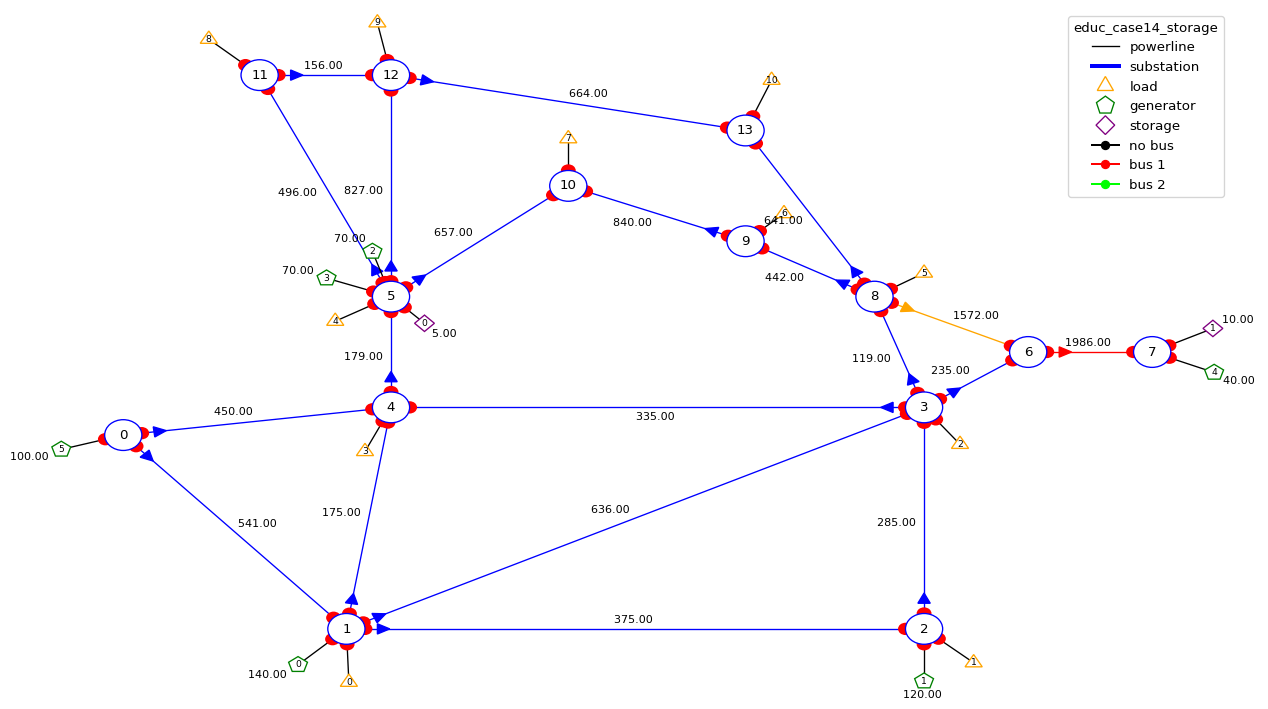

In [11]:
plot_helper = PlotMatplot(env.observation_space)
_ = plot_helper.plot_info(line_values=env._thermal_limit_a, coloring="line", gen_values=env.gen_pmax, storage_values=env.storage_max_p_prod)

In [5]:
stats_reco = EpisodeStatistics(env, name_stats="_reco_powerline")
stats_dn = EpisodeStatistics(env, name_stats="l2rpn_dn")
stats_dn.get("rho")

(array([[0.33895534, 0.35617998, 0.2886046 , ..., 0.78675705, 0.4875496 ,
         0.4509388 ],
        [0.33315462, 0.35314456, 0.28801262, ..., 0.77672225, 0.4833989 ,
         0.44088465],
        [0.319198  , 0.3467046 , 0.27353147, ..., 0.7719445 , 0.48422801,
         0.44299185],
        ...,
        [0.38176566, 0.40527055, 0.32809022, ..., 1.0068276 , 0.5029025 ,
         0.49865094],
        [0.3406469 , 0.39238414, 0.30230325, ..., 1.0116976 , 0.50664663,
         0.50529695],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]], dtype=float32),
 array([[0],
        [0],
        [0],
        ...,
        [6],
        [6],
        [6]]))

In [23]:
stats_dn.get("scores.npz")

(array([25.44393 , 24.873022, 25.141119, ..., 31.84639 , 30.744629,
         1.      ], dtype=float32),
 array([[0],
        [0],
        [0],
        ...,
        [6],
        [6],
        [6]]))

In [13]:
stats_dn.get_metadata()

{'agent_type': "<class 'grid2op.Agent.doNothing.DoNothingAgent'>",
 'agent_seeds': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'env_seeds': [224933033,
  369499290,
  219250107,
  1361544514,
  883910768,
  308197282,
  1974714076,
  1641486691,
  181582956,
  1605544720,
  56259925,
  792673618,
  2126033362,
  1557189083,
  778727145,
  1207915669,
  1804038711,
  2009939665,
  916134734,
  1804402948,
  718702441,
  1511291419,
  655871211,
  276184580,
  1152565312,
  946956883,
  262964322,
  67117281,
  68733439,
  56093347,
  1661467601,
  1895038740,
  2101956523,
  333573436,
  361086138,
  1449029547,
  1133079604,
  1635293811,
  1946434646,
  49941158,
  1667239954,
  184522402

In [48]:
env.observation_space.gen_renewable, env.observation_space.storage_max_p_absorb, env.observation_space.storage_max_p_prod

(array([False, False,  True,  True,  True, False]),
 array([ 5., 10.], dtype=float32),
 array([ 5., 10.], dtype=float32))

In [47]:
obs = env.reset()
obs, reward, done, info = env.step(env.action_space({"curtail": [(2, 1), (3, 0.5)], "set_storage":[(0, -5)]}))
# obs, reward, done, info = env.step(env.action_space())
obs, info

(<grid2op.Space.GridObjects.CompleteObservation_educ_case14_storage_custom at 0x7f0f265f9e50>,
 {'disc_lines': array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1], dtype=int32),
  'is_illegal': False,
  'is_ambiguous': False,
  'is_dispatching_illegal': False,
  'is_illegal_reco': False,
  'reason_alarm_illegal': None,
  'opponent_attack_line': None,
  'opponent_attack_sub': None,
  'opponent_attack_duration': 0,
  'exception': [],
  'rewards': {}})

In [60]:
print(env.action_space({"curtail": [(2, 1), (3, 0.5)], "set_storage":[(0, -5)]}).as_dict())

{'storage_power': array([-5.,  0.], dtype=float32), 'curtailment': array([-1. , -1. ,  1. ,  0.5, -1. , -1. ], dtype=float32)}


In [35]:
obs.curtailment_limit, obs.storage_power

(array([1. , 1. , 1. , 0.5, 1. , 1. ], dtype=float32),
 array([0., 0.], dtype=float32))

In [89]:
sum([getattr(obs, attr_name).shape[0] for attr_name in ["gen_p", "load_p", 
                                      "p_or", "rho", "timestep_overflow", "line_status",
                                      # dispatch part of the observation
                                      "actual_dispatch", "target_dispatch",
                                      # storage part of the observation
                                      "storage_charge", "storage_power",
                                      # curtailment part of the observation
                                      "curtailment", "curtailment_limit",  "gen_p_before_curtail",
                                     ]])+4

135

In [160]:
from run_trained_agents import get_agent

path_agents = "./saved_model/expe_case_14/expe_hp/"
# machine_dir = "GymEnvWithRecoDNShuffle14_rewgp_bs2"
machine_dir = "GymEnvWithRecoDNShuffle14_stor_only_bs"
# name = "GymEnvWithRecoDNShuffle14_rewgp_bs2_20221110_192525_batch_size_2"
name = "GymEnvWithRecoDNShuffle14_stor_only_bs_20221209_171825_batch_size_5" 
training_iter = 1_000_000

root_dir = os.path.abspath(path_agents)
submission_dir  = os.path.join(root_dir, machine_dir)
agent_dir = os.path.join(submission_dir, name)
weights_dir = os.path.join(agent_dir, f"{name}_{training_iter}_steps.zip")

agent = get_agent( # submission_dir,
                                # agent_dir,
                                weights_dir,
                                env,
                                0.2,
                                -1)
gym_env = agent.l2rpn_agent.gymenv
agent

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [161]:
from stable_baselines3 import PPO
nn_model = PPO.load(weights_dir)

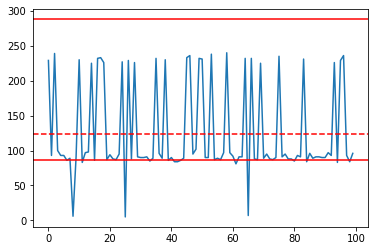

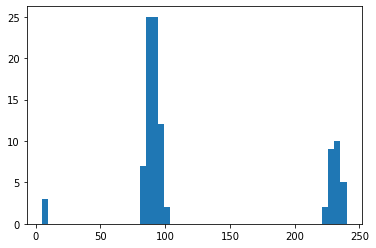

In [61]:
import matplotlib.pyplot as plt
plt.plot([el['l'] for el in nn_model.ep_info_buffer])
plt.axhline(86, color = "r")
plt.axhline(np.mean([el['l'] for el in nn_model.ep_info_buffer]), color = "r", linestyle = "--")
plt.axhline(288, color = "r")
plt.show()
plt.hist([el['l'] for el in nn_model.ep_info_buffer], 50)
plt.show()

In [11]:
from grid2op.utils import ScoreL2RPN2020
score_fun = ScoreL2RPN2020(env,
                               env_seeds=[203375471, 1144983263, 953101846, 1083114570, 1607225939, 356106476, 892894124],
                               nb_scenario=7,
                               min_losses_ratio=0.8,
                               max_step=-1,
                               nb_process_stats=1)

In [16]:
obs = env.reset()
{k:v for k,v in obs.to_dict().items() if k in agent.l2rpn_agent._gym_obs_space._attr_to_keep}

{'timestep_overflow': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       dtype=int32),
 'line_status': array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True]),
 'rho': array([0.35826397, 0.39049447, 0.31809616, 0.2952112 , 0.91025144,
        0.28887725, 0.39001334, 0.60991305, 0.592105  , 0.8619813 ,
        0.27207738, 0.4034889 , 0.3393148 , 0.48397148, 0.43562323,
        0.5725183 , 0.5656107 , 0.9730673 , 0.5062015 , 0.5029044 ],
       dtype=float32),
 'storage_charge': array([7.5, 3.5], dtype=float32),
 'storage_power': array([0., 0.], dtype=float32),
 'gen_p_before_curtail': array([0. , 0. , 9.9, 0. , 0. , 0. ], dtype=float32),
 'curtailment': array([0., 0., 0., 0., 0., 0.], dtype=float32),
 'curtailment_limit': array([1., 1., 1., 1., 1., 1.], dtype=float32)}

In [32]:
print(env.chronics_handler.get_name())

obs = env.reset()
reward = 0
done = False

while not done:
    act = agent.act(obs, reward, done)
    gym_obs = agent.l2rpn_agent._gym_obs_space.to_gym(obs)
    # gym_act = agent.l2rpn_agent.get_act(gym_obs, reward, done)
    gym_act = agent.l2rpn_agent.nn_model.predict(gym_obs, deterministic=True)[0]
    grid2op_act = agent.l2rpn_agent._gym_act_space.from_gym(gym_act)
    obs, reward, done, info = env.step(act)
    if info["is_ambiguous"] or info["is_illegal"] :
        print("AMBIGUOUS ACTION !!!!!!!!!!!!!!!", info)
    print("storate action:", act.as_dict()["storage_power"])
    print("curtailment action:", act.as_dict()["curtailment"])
    print("obs info:", obs.storage_power, obs.curtailment_limit)
   
    

2019-01-16
storate action: [0. 0.]
curtailment action: [-1.         -1.         -1.          0.2221283   0.08803283 -1.        ]
obs info: [0. 0.] [1.         1.         1.         0.2221283  0.08803283 1.        ]
storate action: [0. 0.]
curtailment action: [-1.         -1.         -1.          0.22140622  0.08789662 -1.        ]
obs info: [0. 0.] [1.         1.         1.         0.22140622 0.08789662 1.        ]
storate action: [0. 0.]
curtailment action: [-1.         -1.         -1.          0.2211331   0.08782232 -1.        ]
obs info: [0. 0.] [1.         1.         1.         0.2211331  0.08782232 1.        ]
storate action: [0. 0.]
curtailment action: [-1.         -1.         -1.          0.22141843  0.08781705 -1.        ]
obs info: [0. 0.] [1.         1.         1.         0.22141843 0.08781705 1.        ]
storate action: [0. 0.]
curtailment action: [-1.         -1.         -1.          0.22185947  0.08802443 -1.        ]
obs info: [0. 0.] [1.         1.         1.         0.2

In [93]:
agent.l2rpn_agent.nn_model.policy.log_std

Parameter containing:
tensor([ 1.5612e-04, -7.5294e-05], device='cuda:0', requires_grad=True)

In [176]:
import copy
# activate LIMIT_INFEASIBLE_CURTAILMENT_STORAGE_ACTION parameter
param = gym_env.init_env.parameters
param.LIMIT_INFEASIBLE_CURTAILMENT_STORAGE_ACTION = True
gym_env.init_env.change_parameters(param)

durations_list = []
for j in range(100):
    gym_env.init_env.set_id("2019-01-18")
    obs = gym_env.init_env.reset()
    reward = 0
    done = False
    # i=-1
    # print(env.chronics_handler.get_name())
    while not done:
        # i+=1
        # act = agent.act(obs, reward, done)
        gym_obs = agent.l2rpn_agent._gym_obs_space.to_gym(obs)
        # gym_act = agent.l2rpn_agent.get_act(gym_obs, reward, done)deterministic=False
        gym_act = agent.l2rpn_agent.nn_model.predict(gym_obs, )[0]
        grid2op_act = agent.l2rpn_agent._gym_act_space.from_gym(gym_act)
        grid2op_act = gym_env.fix_action(grid2op_act)
        # obs, reward, done, info = env.step(act)
        obs, reward, done, info = gym_env.init_env.step(grid2op_act)
        if not done:
            obs, reward, done, info = gym_env.apply_heuristics_actions(obs, reward, done, info)
        if info["is_ambiguous"] or info["is_illegal"] :
            print("AMBIGUOUS ACTION !!!!!!!!!!!!!!!", info)
    final_ts = copy.deepcopy(gym_env.init_env.nb_time_step)
    durations_list.append(final_ts)
    # print("storate action:", act.as_dict()["storage_power"])
    # print("curtailment action:", act.as_dict()["curtailment"])
    # print("obs info:", obs.storage_power, obs.curtailment_limit)
   

115.27
124.41


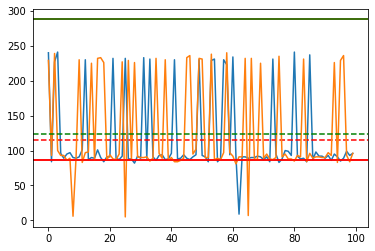

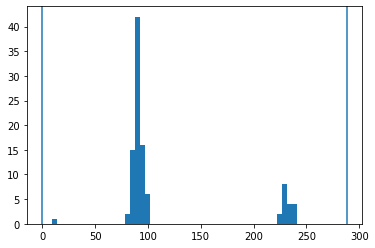

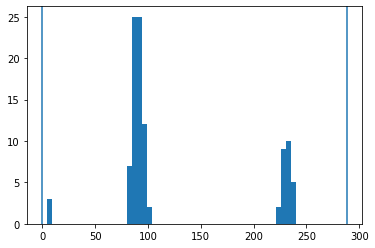

In [178]:
import matplotlib.pyplot as plt

print(np.mean(durations_list))
print(np.mean([el['l'] for el in nn_model.ep_info_buffer]))

plt.plot(durations_list)
plt.axhline(86, color = "r")
plt.axhline(np.mean(durations_list), color = "r", linestyle = "--")
plt.axhline(288, color = "r")
# plt.show()

plt.plot([el['l'] for el in nn_model.ep_info_buffer])
plt.axhline(86, color = "r")
plt.axhline(np.mean([el['l'] for el in nn_model.ep_info_buffer]), color = "g", linestyle = "--")
plt.axhline(288, color = "g")
plt.show()

plt.hist(durations_list, 50)
plt.axvline(0)
plt.axvline(288)
plt.show()

plt.hist([el['l'] for el in nn_model.ep_info_buffer], 50)
plt.axvline(0)
plt.axvline(288)
plt.show()

In [30]:
gym_env.action_space._multiply, gym_env.action_space._add

({'redispatch': array([ 5., 10., 15.], dtype=float32),
  'set_storage': array([ 5., 10.], dtype=float32),
  'curtail': array([1., 1., 1.], dtype=float32)},
 {'redispatch': array([0., 0., 0.], dtype=float32),
  'set_storage': array([0., 0.], dtype=float32),
  'curtail': array([0., 0., 0.], dtype=float32)})

In [37]:
import copy
from typing import Tuple
from grid2op.dtypes import dt_int, dt_bool, dt_float
from grid2op.Action import BaseAction

def limit_curtail_storage(act,
                              obs: "BaseObservation",
                              margin: float=10.,
                              do_copy: bool=False,
                              _tol_equal : float=0.01) -> Tuple["BaseAction", np.ndarray, np.ndarray]:
        """
        This function tries to limit the possibility to end up
        with a "game over" because actions on curtailment or storage units (see the "Notes" section
        for more information).
        
        It will modify the action (unless `do_copy` is `True`) from a given observation `obs`.
        It limits the curtailment / storage unit to ensure that the
        amount of MW curtailed / taken to-from the storage units
        are within `-sum(obs.gen_margin_down)` and `sum(obs.gen_margin_up)`
        
        The `margin` parameter is here to allows to "take into account" the uncertainties. Indeed, if you 
        limit only to `-sum(obs.gen_margin_down)` and `sum(obs.gen_margin_up)`, because you don't know 
        how much the production will vary (due to loads, or intrisinc variability of
        renewable energy sources). The higher `margin` the less likely you will end up with 
        a "game over" but the more your action will possibly be affected. The lower
        this parameter, the more likely you will end up with a game over but the less
        your action will be impacted. It represents a certain amount of `MW`.
        
        Notes
        -------
        
        At each time, the environment ensures that the following equations are met:

        1) for each controlable generators $p^{(c)}_{min} <= p^{(c)}_t <= p^{(c)}_{max}$
        2) for each controlable generators $-ramp_{min}^{(c)} <= p^{(c)}_t - p^{(c)}_{t-1} <= ramp_{max}^{(c)}$
        3) at each step the sum of MW curtailed and the total contribution of storage units 
           is absorbed by the controlable generators so that the total amount of power injected 
           at this step does not change: 
           $\sum_{\text{all generators } g} p^{(g, scenario)}_t = \sum_{\text{controlable generators } c}  p^{(c)}_t + \sum_{\text{storage unit } s} p^{s}_t + \sum_{\text{renewable generator} r} p^{(r)}_t$
           where $p^{(g)}_t$ denotes the productions of generator $g$ in the input data "scenario" 
           (*ie* "in the current episode", "before any modification", "decided by the market / central authority").

        In the above equations, `\sum_{\text{storage unit } s} p^{s}_t` are controled by the action (thanks to the storage units)
        and `\sum_{\text{renewable generator} r} p^{(r)}_t` are controlled by the curtailment.
        
        `\sum_{\text{all generators } g} p^{(g, scenario)}_t` are input data from the environment (that cannot be modify).
        
        The exact value of each `p^{(c)}_t` (for each controlable generator) is computed by an internal routine of the
        environment. 
        
        The constraint comes from the fact that `\sum_{\text{controlable generators } c}  p^{(c)}_t` is determined by the last equation
        above but at the same time the values of each `p^{(c)}_t` (for each controllable generator) is heavily constrained
        by equations 1) and 2).

        .. note::
            This argument and the :func:`grid2op.Parameters.Parameters.LIMIT_INFEASIBLE_CURTAILMENT_STORAGE_ACTION` have the same objective:
            prevent an agent to do some curtailment too strong for the grid.
            
            When using  :func:`grid2op.Parameters.Parameters.LIMIT_INFEASIBLE_CURTAILMENT_STORAGE_ACTION`, 
            the environment will do it knowing exactly what will happen next (its a bit "cheating") and limit 
            exactly the action to exactly right amount.
            
            Using :func:`grid2op.Aciton.BaseAction.limit_curtail_storage` is always feasible, but less precise
            and subject to uncertainties.
        
        .. warning::
            If the action has no effect (for example you give a limit of the curtailment above the
            actual production of renewable generators) then regardless of the "margin" parameter
            your action will be declared "legal" which may cause unfeasibility in the future.
        
        Parameters
        ----------
        obs : ``Observation``
            The current observation. The main attributes used for the observation are 
            `obs.gen_margin_down` and `obs.gen_margin_up`.
            
        margin : ``float``, optional
            The "margin" taken from the controlable generators "margin" to 
            "take into account" when limiting the action 
            (see description for more information), by default 10.
            
        do_copy : ``bool``, optional
            Whether to make a copy of the current action (if set to ``True``) or to modify the
            action "in-place" (default, when ``False``)

        Returns
        -------
        `Action`, np.ndarray, np.ndarray:
            
            - `act`: the action after the storage unit / curtailment are modified (by default it's also `self`)
            - `res_add_curtailed`: the modification made to the curtailment
            - `res_add_storage`: the modification made to the storage units
            
        """
        cls = type(act)
        if do_copy:
            res = copy.deepcopy(act)
        else:
            res = act
            
        res_add_storage = np.zeros(cls.n_storage, dtype=dt_float)
        res_add_curtailed = np.zeros(cls.n_gen, dtype=dt_float)
        
        max_down = np.sum(obs.gen_margin_down)
        max_up = np.sum(obs.gen_margin_up)
        
        # storage
        total_mw_storage = np.sum(res._storage_power)
        total_storage_consumed = np.sum(res._storage_power)
        
        # curtailment
        gen_curtailed = (res._curtail != -1) & cls.gen_renewable
        gen_curtailed &= ( (obs.gen_p > res._curtail * cls.gen_pmax) | (obs.gen_p_before_curtail > obs.gen_p ))
        gen_p_after_max = (res._curtail * cls.gen_pmax)[gen_curtailed]
        
        # I might have a problem because curtailment decreases too rapidly (ie i set a limit too low)
        prod_after_down = np.minimum(gen_p_after_max, obs.gen_p[gen_curtailed])
        # I might have a problem because curtailment increase too rapidly (limit was low and I set it too high too
        # rapidly)
        prod_after_up = np.minimum(gen_p_after_max, obs.gen_p_before_curtail[gen_curtailed])
        gen_p_after = np.maximum(prod_after_down, prod_after_up)
        mw_curtailed = obs.gen_p[gen_curtailed] - gen_p_after
        mw_curtailed_down = 1.0 * mw_curtailed
        mw_curtailed_down[mw_curtailed_down < 0.] = 0.
        mw_curtailed_up = -1.0 * mw_curtailed
        mw_curtailed_up[mw_curtailed_up < 0.] = 0.
        total_mw_curtailed_down = np.sum(mw_curtailed_down)
        total_mw_curtailed_up = np.sum(mw_curtailed_up)
        total_mw_curtailed = total_mw_curtailed_down - total_mw_curtailed_up
        total_mw_act = total_mw_curtailed + total_mw_storage
        
        if (total_mw_act > 0) and (total_mw_act > max_up - margin):
            # controlable generators should be asked to increase their production too much, I need to limit
            # the storage unit (consume too much) or the curtailment (curtailment too strong)
            if max_up < margin + _tol_equal:
                # not enough ramp up anyway so I don't do anything
                res_add_storage[:] = -res._storage_power
                res_add_curtailed[gen_curtailed] = obs.gen_p[gen_curtailed] / obs.gen_pmax[gen_curtailed] - res._curtail[gen_curtailed]
                res._storage_power[:] = 0.  # don't act on storage
                res._curtail[gen_curtailed] = -1  # reset curtailment
                
            else:
                remove_mw = total_mw_act - (max_up - margin)
                # fix curtailment
                if total_mw_curtailed_down > 0.: 
                    remove_curtail_mw = remove_mw * total_mw_curtailed_down / (total_mw_curtailed_down + total_mw_storage)
                    tmp_ = mw_curtailed_down / total_mw_curtailed_down * remove_curtail_mw / cls.gen_pmax[gen_curtailed]
                    res_add_curtailed[gen_curtailed] = tmp_
                    res._curtail[gen_curtailed] += tmp_ 
                    
                # fix storage
                if total_storage_consumed > 0.:
                    # only consider storage units that consume something (do not attempt to modify the others)
                    do_storage_consum = res._storage_power > 0. 
                    remove_storage_mw =  remove_mw * total_mw_storage / (total_mw_curtailed_down + total_mw_storage)
                    tmp_ = -(res._storage_power[do_storage_consum] * 
                             remove_storage_mw / np.sum(res._storage_power[do_storage_consum]))
                    res._storage_power[do_storage_consum] += tmp_
                    res_add_storage[do_storage_consum] = tmp_
                    
        elif (total_mw_act < 0) and (total_mw_act < -max_down + margin):
            # controlable generators should be asked to decrease their production too much, I need to limit
            # the storage unit (produce too much) or the curtailment (curtailment too little)
            if max_down < margin + _tol_equal:
                # not enough ramp down anyway so I don't do anything
                res_add_storage[:] = -res._storage_power
                res_add_curtailed[gen_curtailed] = obs.gen_p[gen_curtailed] / obs.gen_pmax[gen_curtailed] - res._curtail[gen_curtailed]
                res._storage_power[:] = 0.  # don't act on storage
                res._curtail[gen_curtailed] = -1  # reset curtailment
            else:
                add_mw = -(total_mw_act + (max_down - margin))
                # fix curtailment  => does not work at all !
                if total_mw_curtailed_up > 0.: 
                    add_curtail_mw = add_mw * total_mw_curtailed_up / (total_mw_curtailed_up + total_mw_storage)
                    tmp_ = (obs.gen_p_before_curtail[gen_curtailed] * res._curtail[gen_curtailed] - mw_curtailed_up / total_mw_curtailed_up * add_curtail_mw )/ cls.gen_pmax[gen_curtailed]
                    res_add_curtailed[gen_curtailed] = tmp_ - res._curtail[gen_curtailed]
                    res._curtail[gen_curtailed] = tmp_ 
                    
                # fix storage
                if total_storage_consumed < 0.:
                    # only consider storage units that consume something (do not attempt to modify the others)
                    do_storage_prod = res._storage_power < 0. 
                    remove_storage_mw = add_mw * total_mw_storage / (total_mw_curtailed_up + total_mw_storage)
                    tmp_ = (res._storage_power[do_storage_prod] * 
                             remove_storage_mw / np.sum(res._storage_power[do_storage_prod]))
                    res._storage_power[do_storage_prod] += tmp_
                    res_add_storage[do_storage_prod] = tmp_
        return res, res_add_curtailed, res_add_storage


test = agent.l2rpn_agent._gym_act_space.from_gym(gym_act)
print(test)
for el in limit_curtail_storage(test, obs, margin=60, do_copy=True):
    print(el)
for el in test.limit_curtail_storage(obs, margin=60, do_copy=True):
    print(el)

This action will:
	 - NOT change anything to the injections
	 - NOT perform any redispatching action
	 - Modify the storage units in the following way:
	 	 - Ask unit "storage_5_0" to produce 1.08 MW (setpoint: -1.08 MW)
	 	 - Ask unit "storage_7_1" to produce 1.87 MW (setpoint: -1.87 MW)
	 - Perform the following curtailment:
	 	 - Limit unit "gen_5_2" to 62.5% of its Pmax (setpoint: 0.625)
	 	 - Limit unit "gen_5_3" to 22.5% of its Pmax (setpoint: 0.225)
	 	 - Limit unit "gen_7_4" to 8.9% of its Pmax (setpoint: 0.089)
	 - NOT force any line status
	 - NOT switch any line status
	 - NOT switch anything in the topology
	 - NOT force any particular bus configuration
This action will:
	 - NOT change anything to the injections
	 - NOT perform any redispatching action
	 - Modify the storage units in the following way:
	 - Perform the following curtailment:
	 	 - Limit unit "gen_5_2" to 62.5% of its Pmax (setpoint: 0.625)
	 	 - Limit unit "gen_5_3" to 22.5% of its Pmax (setpoint: 0.225)
	 	

In [36]:
print(env.chronics_handler.get_name())

obs = env.reset()
reward = 0
done = False

for i in range(2):
# while not done:
    # Study normalization of observations
    gym_obs = agent.l2rpn_agent._gym_obs_space.to_gym(obs)
    gym_obs_dict = {attr:gym_obs[start:end] for attr, start, end in 
        zip(gym_env.observation_space._attr_to_keep, [0] + gym_env.observation_space._dims[0:-1], gym_env.observation_space._dims)}
    gym_obs_dict_unnormalized = {attr:gym_obs_dict[attr] * gym_env.observation_space._divide[attr] + gym_env.observation_space._subtract[attr]
        for attr in gym_obs_dict.keys()}
    # Study normalization of actions
    act = agent.act(obs, reward, done)
    gym_act = agent.l2rpn_agent.get_act(gym_obs, reward, done)
    gym_act_dict = {attr:gym_act[start:end] for attr, start, end in 
        zip(gym_env.action_space._attr_to_keep, [0] + gym_env.action_space._dims[0:-1], gym_env.action_space._dims)}
    gym_act_dict_unnormalized = {attr:gym_act_dict[attr] * gym_env.action_space._multiply[attr] + gym_env.action_space._add[attr]
        for attr in gym_act_dict.keys()}
    grid2op_act = agent.l2rpn_agent._gym_act_space.from_gym(gym_act)
    grid2op_act_fixed = grid2op_act.copy().limit_curtail_storage(obs, margin=0.6)# gym_env.fix_action(grid2op_act)
    # Print everything
    print("grid2op obs :", {attr:getattr(obs,attr) for attr in gym_env.observation_space._attr_to_keep})
    print("gym_obs_dict:", gym_obs_dict)
    print("gym_obs_dict_unnormalized:", gym_obs_dict_unnormalized)
    print("agent.act result", act)
    # print("act_nn_model_predict:", agent.l2rpn_agent.nn_model.predict(gym_obs, deterministic=True))
    print("gym_act_dict:", gym_act_dict)
    print("gym_act_unnormalized:", gym_act_dict_unnormalized)
    print("grid2op_act:", grid2op_act)
    print("grid2op_act_fixed:", grid2op_act_fixed)
    # Apply the agent's action
    obs, reward, done, info = env.step(act)
    if info["is_ambiguous"] or info["is_illegal"] :
        print("AMBIGUOUS ACTION !!!!!!!!!!!!!!!", info)
    print("_________________________________________")

2019-01-12
grid2op obs : {'curtailment': array([0., 0., 0., 0., 0., 0.], dtype=float32), 'curtailment_limit': array([1., 1., 1., 1., 1., 1.], dtype=float32), 'gen_p': array([81.1     , 79.4     ,  8.4     ,  0.      ,  0.      , 80.524734],
      dtype=float32), 'gen_p_before_curtail': array([0. , 0. , 8.4, 0. , 0. , 0. ], dtype=float32), 'line_status': array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True]), 'load_p': array([22. , 85. , 48.8,  7. , 11.2, 28.6,  8.5,  3. ,  5.9, 12.4, 12.9],
      dtype=float32), 'p_or': array([ 4.1415035e+01,  3.9109699e+01,  2.3489922e+01,  4.1649433e+01,
        3.5031368e+01,  1.7634281e+01, -2.9408319e+01,  8.4553986e+00,
        7.6507158e+00,  1.7268885e+01,  3.2464647e+00,  6.8432441e+00,
       -5.2572546e+00,  1.6588154e+00,  6.2402244e+00,  2.4635784e+01,
        1.4053925e+01,  3.6174999e+01,  5.7731597e-15, -2.4635784e+01],
      dtype

In [26]:
# {attr:gym_obs[start:end] for attr, start, end in 
#     zip(gym_env.observation_space._attr_to_keep, [0] + gym_env.observation_space._dims[0:-1], gym_env.observation_space._dims)}
{attr:getattr(obs,attr) for attr in gym_env.observation_space._attr_to_keep}

{'curtailment': array([0., 0., 0., 0., 0., 0.], dtype=float32),
 'curtailment_limit': array([1., 1., 1., 1., 1., 1.], dtype=float32),
 'gen_p': array([0., 0., 0., 0., 0., 0.], dtype=float32),
 'gen_p_before_curtail': array([0., 0., 0., 0., 0., 0.], dtype=float32),
 'line_status': array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False]),
 'load_p': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32),
 'p_or': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.], dtype=float32),
 'rho': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.], dtype=float32),
 'storage_charge': array([0., 0.], dtype=float32),
 'storage_power': array([0., 0.], dtype=float32),
 'timestep_overflow': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       dtype=int32)}

In [121]:
info

{'disc_lines': array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1], dtype=int32),
 'is_illegal': False,
 'is_ambiguous': False,
 'is_dispatching_illegal': False,
 'is_illegal_reco': False,
 'reason_alarm_illegal': None,
 'opponent_attack_line': None,
 'opponent_attack_sub': None,
 'opponent_attack_duration': 0,
 'exception': [],
 'rewards': {}}

In [4]:
import json
with open("./preprocess_obs.json", "r", encoding="utf-8") as f:
    obs_space_kwargs = json.load(f)
with open("./preprocess_act.json", "r", encoding="utf-8") as f:
    act_space_kwargs = json.load(f)

In [6]:
# agent.l2rpn_agent.nn_model.policy
agent.l2rpn_agent.nn_model.action_space.dict_properties # redispatch, set_storage (already normalized)
# agent.l2rpn_agent.nn_model.observation_space.dict_properties # gen_p (finite), load_p (inf), p_or (inf), rho (0, inf)

{'set_line_status': (array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1], dtype=int32),
  array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        dtype=int32),
  (20,),
  numpy.int32),
 'change_line_status': (array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        dtype=int32),
  array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        dtype=int32),
  (20,),
  numpy.int32),
 'set_bus': (array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1], dtype=int32),
  array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32),
  (

In [44]:
for i in range(len(gym_env.action_space._dims)):
    if i == 0:
        start = 0
    else:
        start = gym_env.action_space._dims[i-1]
    end = gym_env.action_space._dims[i]
    print(gym_env.action_space._attr_to_keep[i], ":", 
            gym_env.action_space.low[start:end], gym_env.action_space.high[start:end])
    print(gym_env.action_space.dict_properties[gym_env.action_space._attr_to_keep[i]][0:2])

curtail : [0. 0. 0.] [1. 1. 1.]
(array([0., 0., 0.], dtype=float32), array([1., 1., 1.], dtype=float32))
set_storage : [-1. -1.] [1. 1.]
(array([-1., -1.], dtype=float32), array([1., 1.], dtype=float32))


Dans `BoxGymActSpace`, `dict_properties` met des limites par defaut sur tous les attributs, il est ensuite mis à jour pour `add` et `multiply` à la fin de `_init_`.  
Dans `BoxGymActSpace`, on ne peut pas utiliser `normalize_attr` sur les attributs dans `add` et `multiply`.
Par construction `action_space.low`, `action_space.high` correspondront toujours à `dict_properties`

Dans `BoxGymObsSpace`, `dict_properties` met des limites par defaut sur tous les attributs, mais il n'est pas corrigé ensuite pour `subtract` et `divide` à cause des lignes `low_ =  low_.astype(dtype), high_ =  high_.astype(dtype)`.  
Cependant `observation_space.low`, `observation_space.high` prennent bien en compte `subtract` et `divide`.  
Ici aussi, on ne peut pas utiliser `normalize_attr` sur les attributs dans `subtract` et `divide`.
La fonction `to_gym` applique `subtract` et `divide` mais ne fait pas la normalisation pour les autres de base. Il faut faire au préalable `observation_space.normalize_attr("other_attr")` pour ajouter `"other_attr"` et les valeurs correspondantes dans `subtract` et `divide`. Dans notre code ceci est fait dans le fichier `l2rpn_baselines/PPO_SB3/train.py` si l'option est sélectionnée.

Il y a une asymétrie concernant le traitement de `dict_properties` pour les actions et les observations, mais à priori cela n'a pas d'impact dans notre application car nous n'utilisons pas ce dictionnaire.

/!\ On a un problème quand on charge l'agent avec `get_agent`, les espaces d'actions et d'observations sont reconstruits et donc les normalize_attr ne sont plus pris en compte pour les attributs qui ne sont pas dans `obs_attr_kwargs` et `act_attr_kwargs`.

In [200]:
from grid2op.gym_compat import BoxGymObsSpace

# Reset obs_space_kwargs to remove normalization
test = BoxGymObsSpace(env.observation_space, ["gen_p","year"], subtract=obs_space_kwargs["subtract"], divide=obs_space_kwargs["divide"])
# test.normalize_attr("year")
print("low:", test.low)
print("high:", test.high) 
print("dict:", test.dict_properties["gen_p"], test.dict_properties["year"])
print("gym_obs:", test.to_gym(obs))

low: [-30.90674  -31.372768 -16.351053 -21.497858 -37.143448 -29.688648
   0.      ]
high: [28.915142 27.132763 19.779127 29.269342 44.90924  23.367273  1.      ]
dict: (array([-162.01, -162.01, -162.01, -162.01, -162.01, -162.01],
      dtype=float32), array([302.01   , 282.01   , 232.01001, 232.01001, 202.01   , 262.01   ],
      dtype=float32), (6,), <class 'numpy.float32'>) (array([0], dtype=int32), array([2200], dtype=int32), (1,), <class 'numpy.int32'>)
gym_obs: [ 0.43522218  0.43620348 -0.7250852  -0.62380534 -0.6252446   0.6587491
  0.9177273 ]


In [188]:
from grid2op.gym_compat import BoxGymObsSpace

truc = None
truc = BoxGymObsSpace(env.observation_space, ["gen_p","year"], subtract=obs_space_kwargs["subtract"], divide=obs_space_kwargs["divide"])
# test.normalize_attr("year")
print("low:", truc.low)
print("high:", truc.high) 
print("dict:", truc.dict_properties["gen_p"], truc.dict_properties["year"])
print("_divide:", test._divide.keys())

low: [-30.90674  -31.372768 -16.351053 -21.497858 -37.143448 -29.688648
   0.      ]
high: [28.915142 27.132763 19.779127 29.269342 44.90924  23.367273  1.      ]
dict: (array([-162.01, -162.01, -162.01, -162.01, -162.01, -162.01],
      dtype=float32), array([302.01   , 282.01   , 232.01001, 232.01001, 202.01   , 262.01   ],
      dtype=float32), (6,), <class 'numpy.float32'>) (array([0], dtype=int32), array([2200], dtype=int32), (1,), <class 'numpy.int32'>)
_divide: dict_keys(['gen_p', 'load_p', 'p_or', 'rho', 'year'])


In [20]:
from GymEnvWithRecoWithDNWithShuffle import GymEnvWithRecoWithDNWithShuffle
from stable_baselines3 import PPO
agent_test = PPO.load(weights_dir)

In [ ]:
from l2rpn_baselines.PPO_SB3.utils import SB3Agent
from grid2op.gym_compat import BoxGymActSpace, BoxGymObsSpace
from GymEnvWithRecoWithDNWithShuffle import GymEnvWithRecoWithDNWithShuffle
from run_trained_agents import BaselineAgent

def get_agent(submission_dir, agent_dir, weights_dir, env, safe_max_rho, limit_cs_margin):
    """this is basically a copy paste of the PPO_SB3 evaluate function with some minor modification
    used to load the correct weights
    """
    
    # compute the score of said agent
    with open(os.path.join(submission_dir, "preprocess_obs.json"), 'r', encoding="utf-8") as f:
        obs_space_kwargs = json.load(f)
    with open(os.path.join(submission_dir, "preprocess_act.json"), 'r', encoding="utf-8") as f:
        act_space_kwargs = json.load(f)
    
    # load the attributes kept
    with open(os.path.join(agent_dir, "obs_attr_to_keep.json"), encoding="utf-8", mode="r") as f:
        obs_attr_to_keep = json.load(fp=f)
    with open(os.path.join(agent_dir, "act_attr_to_keep.json"), encoding="utf-8", mode="r") as f:
        act_attr_to_keep = json.load(fp=f)

    # create the action and observation space
    gym_observation_space =  BoxGymObsSpace(env.observation_space,
                                            attr_to_keep=obs_attr_to_keep,
                                            **obs_space_kwargs)
    gym_action_space = BoxGymActSpace(env.action_space,
                                      attr_to_keep=act_attr_to_keep,
                                      **act_space_kwargs)
    
    # create the gym environment for the PPO agent...
    gymenv = GymEnvWithRecoWithDNWithShuffle(env, safe_max_rho=float(safe_max_rho))    
    gymenv.action_space.close()
    gymenv.action_space = gym_action_space
    gymenv.observation_space.close()
    gymenv.observation_space = gym_observation_space
    
    # create a grid2gop agent based on that (this will reload the save weights)
    l2rpn_agent = SB3Agent(env.action_space,
                           gym_action_space,
                           gym_observation_space,
                           nn_path=weights_dir,
                           gymenv=gymenv
                           )
    
    agent_to_evaluate = BaselineAgent(l2rpn_agent, limit_cs_margin)
    return agent_to_evaluate

In [6]:
from l2rpn_baselines.PPO_SB3.utils import SB3Agent
from grid2op.gym_compat import BoxGymActSpace, BoxGymObsSpace
from GymEnvWithRecoWithDNWithShuffle import GymEnvWithRecoWithDNWithShuffle
from run_trained_agents import BaselineAgent
from stable_baselines3 import PPO

def get_agent_new(weights_dir, env, safe_max_rho, limit_cs_margin, gym_observation_space=None, gym_action_space=None, nn_type=PPO):
    """this is basically a copy paste of the PPO_SB3 evaluate function with some minor modification
    used to load the correct weights
    """
    nn_model = nn_type.load(weights_dir)
    if gym_observation_space is None:
        gym_observation_space = nn_model.observation_space
    if gym_action_space is None:
        gym_action_space = nn_model.action_space

    # compute the score of said agent
    # with open(os.path.join(submission_dir, "preprocess_obs.json"), 'r', encoding="utf-8") as f:
    #     obs_space_kwargs = json.load(f)
    # with open(os.path.join(submission_dir, "preprocess_act.json"), 'r', encoding="utf-8") as f:
    #     act_space_kwargs = json.load(f)
    
    # # load the attributes kept
    # with open(os.path.join(agent_dir, "obs_attr_to_keep.json"), encoding="utf-8", mode="r") as f:
    #     obs_attr_to_keep = json.load(fp=f)
    # with open(os.path.join(agent_dir, "act_attr_to_keep.json"), encoding="utf-8", mode="r") as f:
    #     act_attr_to_keep = json.load(fp=f)


    # create the action and observation space
    # gym_observation_space =  BoxGymObsSpace(env.observation_space,
    #                                         attr_to_keep=obs_attr_to_keep,
    #                                         **obs_space_kwargs)
    # gym_action_space = BoxGymActSpace(env.action_space,
    #                                   attr_to_keep=act_attr_to_keep,
    #                                   **act_space_kwargs)
    
    # create the gym environment for the PPO agent...
    gymenv = GymEnvWithRecoWithDNWithShuffle(env, safe_max_rho=float(safe_max_rho))    
    gymenv.action_space.close()
    gymenv.action_space = gym_action_space
    gymenv.observation_space.close()
    gymenv.observation_space = gym_observation_space
    
    # create a grid2gop agent based on that (this will reload the save weights)
    l2rpn_agent = SB3Agent(env.action_space,
                           gym_action_space,
                           gym_observation_space,
                           nn_path=weights_dir,
                           gymenv=gymenv
                           )
    
    agent_to_evaluate = BaselineAgent(l2rpn_agent, limit_cs_margin)
    return agent_to_evaluate

In [7]:
from run_trained_agents import get_agent
agent = get_agent(submission_dir,
                                agent_dir,
                                weights_dir,
                                env,
                                0.2,
                                60)

agent
agent_new = get_agent_new(weights_dir,
                                env,
                                0.2,
                                60)

agent_new

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [8]:
agent.l2rpn_agent.gymenv.action_space._add, agent_new.l2rpn_agent.gymenv.action_space._add

({'redispatch': array([0., 0., 0.], dtype=float32),
  'set_storage': array([0., 0.], dtype=float32),
  'curtail': array([0., 0., 0.], dtype=float32)},
 {'redispatch': array([0., 0., 0.], dtype=float32),
  'set_storage': array([0., 0.], dtype=float32),
  'curtail': array([0., 0., 0.], dtype=float32)})

In [50]:
from l2rpn_baselines.PPO_SB3.utils import SB3Agent
test = SB3Agent(env.action_space,
                           gym_env.action_space,
                           gym_env.observation_space,
                           nn_path=weights_dir,
                           gymenv=gym_env
                           )
obs = env.reset()
test.act(obs, 0, False)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [45]:
agent.l2rpn_agent.nn_model

In [43]:
for i in range(len(gym_env.observation_space._dims)):
    if i == 0:
        start = 0
    else:
        start = gym_env.observation_space._dims[i-1]
    end = gym_env.observation_space._dims[i]
    print(gym_env.observation_space._attr_to_keep[i], ":", 
            gym_env.observation_space.low[start:end], gym_env.observation_space.high[start:end])
    print(gym_env.observation_space.dict_properties[gym_env.observation_space._attr_to_keep[i]][0:2])
# low and high = dict_properties scaled for observations for attr in subtract and divide

curtailment : [0. 0. 0. 0. 0. 0.] [1. 1. 1. 1. 1. 1.]
(array([0., 0., 0., 0., 0., 0.], dtype=float32), array([1., 1., 1., 1., 1., 1.], dtype=float32))
curtailment_limit : [0. 0. 0. 0. 0. 0.] [1. 1. 1. 1. 1. 1.]
(array([0., 0., 0., 0., 0., 0.], dtype=float32), array([1., 1., 1., 1., 1., 1.], dtype=float32))
gen_p : [-30.90674  -31.372768 -16.351053 -21.497858 -37.143448 -29.688648] [28.915142 27.132763 19.779127 29.269342 44.90924  23.367273]
(array([-162.01, -162.01, -162.01, -162.01, -162.01, -162.01],
      dtype=float32), array([302.01   , 282.01   , 232.01001, 232.01001, 202.01   , 262.01   ],
      dtype=float32))
gen_p_before_curtail : [-162.01 -162.01 -162.01 -162.01 -162.01 -162.01] [302.01    282.01    232.01001 232.01001 202.01    262.01   ]
(array([-162.01, -162.01, -162.01, -162.01, -162.01, -162.01],
      dtype=float32), array([302.01   , 282.01   , 232.01001, 232.01001, 202.01   , 262.01   ],
      dtype=float32))
line_status : [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

In [46]:
obs = env.reset()
action = env.action_space({"curtail": [(2, 1), (3, 0.5)], "set_storage":[(0, -5)]})

In [58]:
{attr:getattr(obs, attr) for attr in gym_env.observation_space._attr_to_keep}

{'curtailment': array([0., 0., 0., 0., 0., 0.], dtype=float32),
 'curtailment_limit': array([1., 1., 1., 1., 1., 1.], dtype=float32),
 'gen_p': array([81.1     , 79.4     ,  8.4     ,  0.      ,  0.      , 80.524734],
       dtype=float32),
 'gen_p_before_curtail': array([0. , 0. , 8.4, 0. , 0. , 0. ], dtype=float32),
 'line_status': array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True]),
 'load_p': array([22. , 85. , 48.8,  7. , 11.2, 28.6,  8.5,  3. ,  5.9, 12.4, 12.9],
       dtype=float32),
 'p_or': array([ 4.1415035e+01,  3.9109699e+01,  2.3489922e+01,  4.1649433e+01,
         3.5031368e+01,  1.7634281e+01, -2.9408319e+01,  8.4553986e+00,
         7.6507158e+00,  1.7268885e+01,  3.2464647e+00,  6.8432441e+00,
        -5.2572546e+00,  1.6588154e+00,  6.2402244e+00,  2.4635784e+01,
         1.4053925e+01,  3.6174999e+01,  5.7731597e-15, -2.4635784e+01],
       dtype=float32),

In [59]:
gym_obs = gym_env.observation_space.to_gym(obs)
gym_act = agent.l2rpn_agent.get_act(gym_obs, 0, False)
gym_env.action_space.from_gym(gym_act).as_dict()

{'storage_power': array([-1.0661299, -1.8376714], dtype=float32),
 'curtailment': array([-1.        , -1.        ,  0.61239845,  0.21962093,  0.08623188,
        -1.        ], dtype=float32)}

In [84]:
for i in range(len(gym_env.observation_space._dims)):
    if i == 0:
        start = 0
    else:
        start = gym_env.observation_space._dims[i-1]
    end = gym_env.observation_space._dims[i]
    print(gym_env.observation_space._attr_to_keep[i], ":", gym_obs[start:end])

print({k: (getattr(obs,k) - obs_space_kwargs['subtract'][k])/obs_space_kwargs['divide'][k] 
    for k in gym_env.observation_space._attr_to_keep if k in obs_space_kwargs['subtract'].keys()})

curtailment : [0. 0. 0. 0. 0. 0.]
curtailment_limit : [1. 1. 1. 1. 1. 1.]
gen_p : [ 0.43522218  0.43620348 -0.7250852  -0.62380534 -0.6252446   0.6587491 ]
gen_p_before_curtail : [0.  0.  8.4 0.  0.  0. ]
line_status : [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
load_p : [ 0.5561861  -0.54716504  0.5750381  -0.28923225  0.33912984  0.07553835
 -0.11183602 -0.34506464  0.08847857 -0.26215902 -0.88684   ]
p_or : [ 0.4383072   0.8329436  -0.7425402   0.78572     0.9130217   1.4493761
  0.27487427 -0.8077287  -0.3796828  -0.6047391   0.8964688   0.2361009
  0.7661646  -0.52811766 -0.9737515   0.87201405  0.86091554  1.0142995
  0.6252446  -0.3129524 ]
rho : [ 0.01473814  0.03032282 -0.03185767  0.0211238   0.08461636  0.063299
 -0.01329887 -0.05826628 -0.01852429 -0.05348825  0.06889462 -0.0191873
 -0.03178546 -0.07468337 -0.05994064  0.06419131  0.05869201  0.19158846
 -0.00789621  0.00799766]
storage_charge : [7.5 3.5]
storage_power : [0. 0.]
timestep_overflow : [0. 0. 

In [237]:
from l2rpn_baselines.PPO_SB3.utils import SB3Agent
from stable_baselines3 import PPO

PPO.load(weights_dir)
# SB3Agent.load(weights_dir)

In [ ]:
def to_gym_acts(env_gym, g2op_actions):
    gym_actions = []
    for g2op_act in g2op_actions:
        gym_act = np.zeros((0,))
        for attr_nm in env_gym.action_space._attr_to_keep :
            this_part_act = getattr(g2op_act, attr_nm).copy()
            if attr_nm == "curtail" or attr_nm == "curtail_mw":
                this_part_act = this_part_act[env_gym.init_env.action_space.gen_renewable]
            if attr_nm == "redispatch":
                this_part_act = this_part_act[env_gym.init_env.action_space.gen_redispatchable]
            this_part_act = (this_part_act - env_gym.action_space._add[attr_nm]) / env_gym.action_space._multiply[attr_nm]
            gym_act = np.concatenate((gym_act, this_part_act))
        gym_actions.append(gym_act)
    return gym_actions

def unnormalize_gym_obss(gym_env, gym_obss):
    un_obss = []
    g2op_obs = env.reset()
    for gym_obs in gym_obss:
        un_obs = np.copy(gym_obss)
        prev = 0
        for attr_tmp, where_to_put in zip(gym_env.observation_space._attr_to_keep, gym_env.observation_space._dims):
            res = gym_obs[prev:where_to_put]
            if attr_tmp in gym_env.observation_space._divide:
                res *= gym_env.observation_space._divide[attr_tmp]
            if attr_tmp in gym_env.observation_space._subtract:
                res += gym_env.observation_space._subtract[attr_tmp]
            # Ajouter l'etape avec low et high
            # Regarder ce qu'il se passe quand l'attribut est a la fois dans low et high et dans divide et subtract
            un_obs[prev:where_to_put] = res
            prev = where_to_put
        un_obss.append(un_obs)
    return un_obss

In [33]:
gym_env.observation_space._divide.keys()

dict_keys(['gen_p', 'load_p', 'p_or', 'rho'])

In [26]:
gym_env.observation_space

Box([ 0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
 -3.0906740e+01 -3.1372768e+01 -1.6351053e+01 -2.1497858e+01
 -3.7143448e+01 -2.9688648e+01 -1.6200999e+02 -1.6200999e+02
 -1.6200999e+02 -1.6200999e+02 -1.6200999e+02 -1.6200999e+02
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
           -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
           -inf     

In [17]:
agent.l2rpn_agent.gymenv.action_space.dict_properties

{'set_line_status': (array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1], dtype=int32),
  array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        dtype=int32),
  (20,),
  numpy.int32),
 'change_line_status': (array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        dtype=int32),
  array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        dtype=int32),
  (20,),
  numpy.int32),
 'set_bus': (array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1], dtype=int32),
  array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32),
  (

In [14]:
agent.l2rpn_agent.gymenv.observation_space.to_gym(obs)
# agent.l2rpn_agent.gymenv.action_space.from_gym(action)

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  1.00000000e+00,  1.00000000e+00,
        1.00000000e+00,  1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
        1.65997088e+00,  1.68795466e+00, -5.87540746e-01, -6.23805344e-01,
       -6.25244617e-01,  1.58348346e+00,  0.00000000e+00,  0.00000000e+00,
        9.89999962e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        1.00000000e+00,  1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
        1.00000000e+00,  1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
        1.00000000e+00,  1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
        1.00000000e+00,  1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
        1.00000000e+00,  1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
        2.24707693e-01,  7.76324153e-01,  6.89177334e-01,  9.10767555e-01,
        9.16688204e-01,  9.33885813e-01,  8.23715448e-01,  3.54935408e-01,
        8.88478279e-01,  

In [4]:
for name, weight in agent.l2rpn_agent.nn_model.policy.named_parameters():
    print(name, weight)

log_std Parameter containing:
tensor([-0.0071,  0.0016,  0.0008, -0.0007, -0.0046], device='cuda:0',
       requires_grad=True)
mlp_extractor.shared_net.0.weight Parameter containing:
tensor([[ 0.0592,  0.1159,  0.0545,  ..., -0.0113, -0.0114, -0.1133],
        [-0.0111,  0.0437,  0.0131,  ..., -0.0539, -0.0499, -0.0901],
        [ 0.1623,  0.0137,  0.0366,  ..., -0.1071,  0.0791,  0.0418],
        ...,
        [ 0.0183,  0.1312, -0.0176,  ..., -0.0227,  0.0200,  0.0610],
        [ 0.0723,  0.0984, -0.0725,  ..., -0.0257, -0.0522,  0.1866],
        [ 0.0164, -0.0261,  0.0673,  ..., -0.0147,  0.0453,  0.0015]],
       device='cuda:0', requires_grad=True)
mlp_extractor.shared_net.0.bias Parameter containing:
tensor([-1.0582e-02,  1.0005e-03,  1.1263e-02,  9.2413e-03,  2.3841e-03,
        -3.9605e-03, -3.3353e-04, -2.0337e-02,  2.5985e-03, -8.1719e-04,
         5.4805e-03,  5.7216e-03,  8.1322e-03,  5.1222e-04, -3.5111e-03,
        -7.0870e-03, -5.7130e-03,  1.2621e-02, -1.0997e-02, -3.22

## Test with OptimCVX agent

In [4]:
# import os
from l2rpn_baselines.OptimCVXPY import OptimCVXPY
from grid2op.utils import ScoreL2RPN2022
from grid2op.Parameters import Parameters
from utils import *
# from tqdm import tqdm
# import pdb
# import re
# import copy
# from datetime import datetime
# import torch

2022-11-08 11:39:58.064882: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-08 11:39:58.064904: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/boguslawskieva/miniconda3/envs/baselines_dev/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
ENV_NAME = "educ_case14_storage_custom"
SCOREUSED = ScoreL2RPN2022
verbose = True
p = Parameters()
p.LIMIT_INFEASIBLE_CURTAILMENT_STORAGE_ACTION = False
train_args = {}
train_args["gymenv_kwargs"] = {"safe_max_rho": 0.2}
nb_scenario = 7

In [6]:
env = grid2op.make(ENV_NAME,
                    backend=LightSimBackend(),
                    param=p
                    )

In [18]:
agent = OptimCVXPY(env.action_space,
                   env,
                   penalty_redispatching_unsafe=100,
                   penalty_redispatching_safe=100,
                   penalty_storage_unsafe=0.01,
                   penalty_curtailment_unsafe=0.01,
                   rho_safe=0.2,
                   rho_danger=0.8,
                   margin_th_limit=0.93,
                   alpha_por_error=0.5,
                   weight_redisp_target=0.3)

In [19]:
results = eval_agent(ENV_NAME,
                nb_scenario,
                "agent_optim",
                "load_path",
                SCOREUSED,
                verbose,
                gymenv_kwargs=train_args["gymenv_kwargs"],
                param=p,
                my_agent=agent
                )
results

Starts the evaluation of the agent
Start the evaluation of the scores


([288, 288, 227, 227, 288, 233, 95],
 array([288, 288, 220,  90, 236, 234,  86]),
 array([288, 288, 220,  90, 236, 234,  86]))